# 📈 Stock Price Prediction with LSTM (PyTorch)
### Predict future stock prices using an LSTM-based deep learning model.


In [75]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from StockETL import GlobalPath

In [76]:
symbol = "TATAMOTORS" # "TATAPOWER", "BAJAJHFL", "UNITDSPR"
time_step = 60
epochs = 50
today = datetime.today()

In [77]:
# Load and Prepare Data
df = pd.read_csv("https://raw.githubusercontent.com/PtPrashantTripathi/PortfolioTracker/refs/heads/main/DATA/SILVER/StockPrice/StockPrice_data.csv")

# Convert datetime column to date and process data
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Filter Data
df = df[(df["symbol"] == symbol) & (df["date"] >= (today - timedelta(days=365 * 2)))]
if df.empty:
    raise ValueError("No data found for the selected symbol and date range.")
df = df.set_index("date")
df = df[["close"]]
df.head()

,close
date,
2023-05-15,527.57
2023-05-16,517.93
2023-05-17,512.32
2023-05-18,505.31
2023-05-19,521.71


In [78]:
print("\nMissing values in Close column:", df["close"].isna().sum())
print("\nStatistical Summary:")
print(df.describe())


Missing values in Close column: 0

Statistical Summary:
             close
count   415.000000
mean    801.696361
std     174.955091
min     505.310000
25%     633.920000
50%     786.670000
75%     970.380000
max    1161.850000


In [79]:
# Preprocess
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df["close"].values.reshape(-1, 1))
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


def create_dataset(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step : i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [80]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=200, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [81]:
# Train
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train.unsqueeze(-1))
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

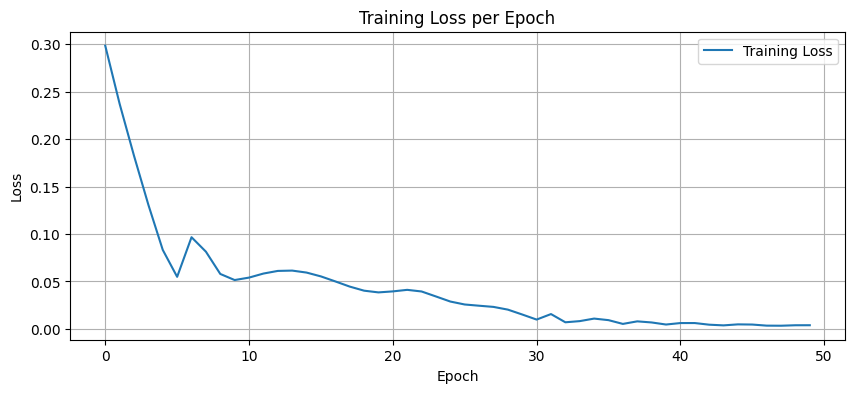

In [82]:
# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [83]:
# Test
model.eval()
with torch.no_grad():
    predictions = model(X_test.unsqueeze(-1)).squeeze()
    test_loss = criterion(predictions, y_test).item()
print(f"\nTest Loss (MSE): {test_loss:.5f}")


Test Loss (MSE): 0.00601


In [84]:
# Actual vs Predicted
full_actual = scaler.inverse_transform(scaled_data)
full_predicted = np.empty_like(full_actual)
full_predicted[:] = np.nan
test_start_index = train_size + time_step
full_predicted[test_start_index : test_start_index + len(predictions)] = (
    scaler.inverse_transform(predictions.detach().numpy().reshape(-1, 1))
)

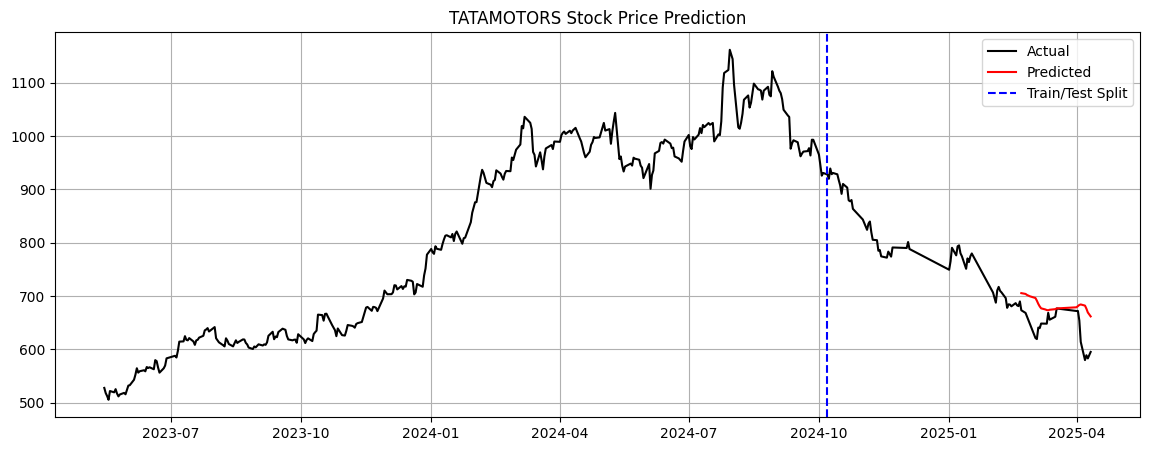

In [85]:
# Plot Actual vs Predicted
plt.figure(figsize=(14, 5))
plt.plot(df.index, full_actual, label="Actual", color="black")
plt.plot(df.index, full_predicted, label="Predicted", color="red")
plt.axvline(
    df.index[train_size], color="blue", linestyle="--", label="Train/Test Split"
)
plt.title(f"{symbol} Stock Price Prediction")
plt.legend()
plt.grid()
plt.show()

In [86]:
# Future Forecast
last_60_days = scaled_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []

with torch.no_grad():
    for _ in range(30):
        input_tensor = torch.tensor(last_60_days).float()
        predicted = model(input_tensor)
        future_predictions.append(predicted.item())
        last_60_days = np.roll(last_60_days, -1)
        last_60_days[0, -1, 0] = predicted.item()

future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)
future_dates = pd.date_range(start=today + timedelta(days=1), periods=30)

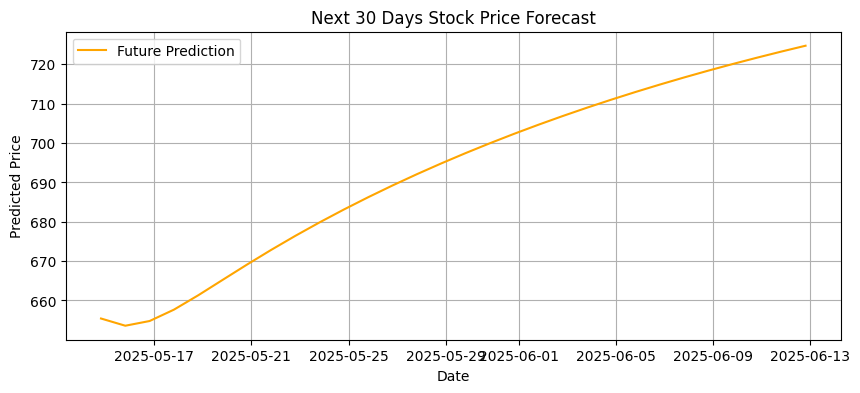

In [87]:
# Plot future predictions
plt.figure(figsize=(10, 4))
plt.plot(future_dates, future_predictions, color="orange", label="Future Prediction")
plt.title("Next 30 Days Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid()
plt.show()